## SLALOM Case-Study: Construcing and analzying failure cases in sequence classification

In this notebook we show how SLALOM's two-dimensional representation can be used to identify potential failure cases in a BERT model.

In [1]:
import os
os.chdir("..")

In [2]:
%load_ext autoreload
%autoreload 2

## Load examples from the IMDB dataset

In [3]:
from datasets import load_dataset, DatasetDict, concatenate_datasets
imdb_og = load_dataset('imdb').with_format('torch', device="cuda")
imdb = DatasetDict({"train": concatenate_datasets([imdb_og["train"], imdb_og["test"]]), "test": imdb_og["test"], "val": imdb_og["train"].shuffle(seed=42).select(range(5000))}) # train: 50k samples (train+test), test: original 25k samples
imdb_val = DatasetDict({"train": imdb_og["train"].shuffle(seed=42).select(range(5000)), "test": imdb_og["train"].shuffle(seed=42).select(range(5000))})
print(imdb_val)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 5000
    })
})


## Load a pretrained model

To run this notebook, first train the models on the IMDB dataset with the script

```
./scripts/train_models.py
```
To train only one model run:

``` export PYTHONPATH="."; python3 slalom_explanations/train_models.py --layers 6 --model bert --dataset imdb --epochs 2 --log_attn_steps 200 --lr 1e-5 --runid 7 --pretrained --device cuda:0 ```

to train the models on IMDB.

In [7]:
from transformers import AutoTokenizer

# Use a trained model here
run_long = "yelp_bert_6_pretrained_r7"

import torch
path ="/mnt/ssd3/user/AttentionMatricesRaw/models" ## Insert your folder to the trained models here!
s_dict = torch.load(f"{path}/{run_long}.pt", weights_only=False)

run_long = "bert"
if "gpt" in run_long:
    tokenizer = AutoTokenizer.from_pretrained('distilgpt2', use_fast=True)
else:
    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', use_fast=True)

In [8]:
from slalom_explanations.transformer_models import Bert, GPT2
if "gpt" in run_long:
    model_obj = GPT2(n_layers=6, n_heads=12, pretrained=True)
    use_cls = False
else: 
    model_obj = Bert(n_layers=6, n_heads=12, pretrained=True)
    use_cls = True
    #if "bert.embeddings.position_ids" not in s_dict: # Patch different keys in transformer versions.
    #    s_dict["bert.embeddings.position_ids" ] = torch.arange(512).reshape(1, -1)
model_obj.model.load_state_dict(s_dict)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

In [9]:
from slalom_explanations.attribution_methods import SLALOMLocalExplanantions

## Select an example from the IMDB dataset
Here we select an example with a postive rating. We will explore how SLALOM can be used to explore possible failure cases of examples similar to the model.

In [103]:
example = imdb_val["test"][14]

In [104]:
example["text"]

"when my sister said this movie was gonna be good i had second thoughts but i watched it and it was actually funny. basically the movie is made of a weird girl who goes to a small town where no one likes her and she just wants to go there and get the reading of her aunts will don so she can go. but its not all that easy. In this movie you will come across hilarious humor, a witch, a book of spells/recopies, a mentally challenged uncle and a dog. You will understand the meaning of the word freak a after anyways i hope you run right out and try to find this really old movie. hope you like it in total i will have to give it a 0.... no I'm totally joking ill give it a 9 hope you understand that you will laugh, you will scream and you may just be offended.<br /><br />love yours truly: Dakota you can email me at dakota_loves_it@hot mail.com if you wanna"

In [195]:
## Run a forward pass on the sample
def forward_text(input_text):
    model_obj.model.cpu()
    res = model_obj.model(**tokenizer([input_text], return_tensors="pt"))
    print("Logit score: ", (res.logits[0,1]-res.logits[0,0]).item())
forward_text(example["text"])

Logit score:  1.500072956085205


A postive logit score indicates a positive classification, a negative score indicates a negative classification. The example initially has a positive rating. We will now use SLALOM to discover possible modifications that will make the model interpret the example as a negative decision,
thereby showcasing vulnerabilities and potential spurious correlations that can be uncovered with our approach.

While we can explain a single sample, SLALOM also offers the possibility to explain different samples at once (basically by concatenation of the words).

In [193]:
# Tokenize some examples to explain with SLALOM

input_arr_list = []
for i in range(15):
    input_array = torch.tensor(tokenizer.encode(imdb_val["test"][i]["text"]))
    if use_cls:
        input_array = input_array[1:-1]
    input_arr_list.append(input_array)
all_tokens = torch.cat(input_arr_list)

In [194]:
# The tokenized version of the text.
len(all_tokens)

4187

We compute SLALOM Explanations to learn more about how this classification decision was made.

In [196]:
myslalomeff = SLALOMLocalExplanantions(model_obj.model, device="cuda", sgd_lr= 1e-2, sgd_epochs= 50, modes = ["lin"], n_samples = 5000, seq_len= 2)

In [197]:
res_slalom = myslalomeff.get_signed_importance_for_tokens(all_tokens)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.26it/s]


In [198]:
myslalomeff.curr_slalom_model

MyLittleSLALOM()

In [199]:
unique_tokens = all_tokens.unique()

In [202]:
len(unique_tokens)

1258

In [204]:
import matplotlib.pyplot as plt
def visualize_importances(unique_tokens, tokenizer, slalom_model, ylim=None):
    tok_str_list = tokenizer.convert_ids_to_tokens(unique_tokens)
    slalom_imp = slalom_model.get_importances().cpu()
    slalom_val = slalom_model.get_values().cpu()
    for i, (tok_v, tok_str) in enumerate(zip(unique_tokens, tok_str_list)):
        tok_str = tok_str.replace("Ġ", "") ## For GPT2-tokens
        plt.scatter([slalom_val[i]], [slalom_imp[i]], 3, c="tab:blue")
        plt.annotate(tok_str, xy=(slalom_val[i], slalom_imp[i]), fontsize=6)
    plt.xlabel("value score")
    if ylim is not None:
        plt.ylim(ylim)
    plt.ylabel("importance score")
    plt.gcf().set_size_inches(12,12)

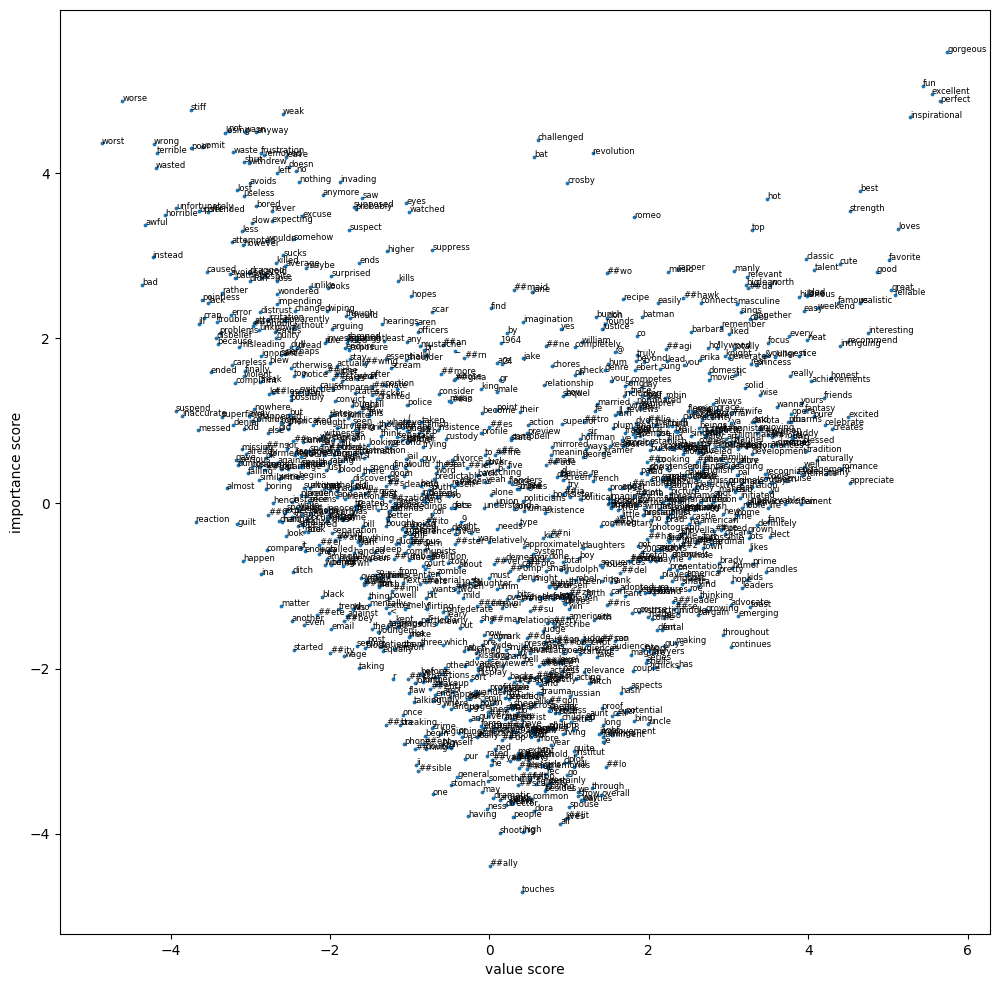

In [201]:
visualize_importances(unique_tokens, tokenizer, myslalomeff.curr_slalom_model)

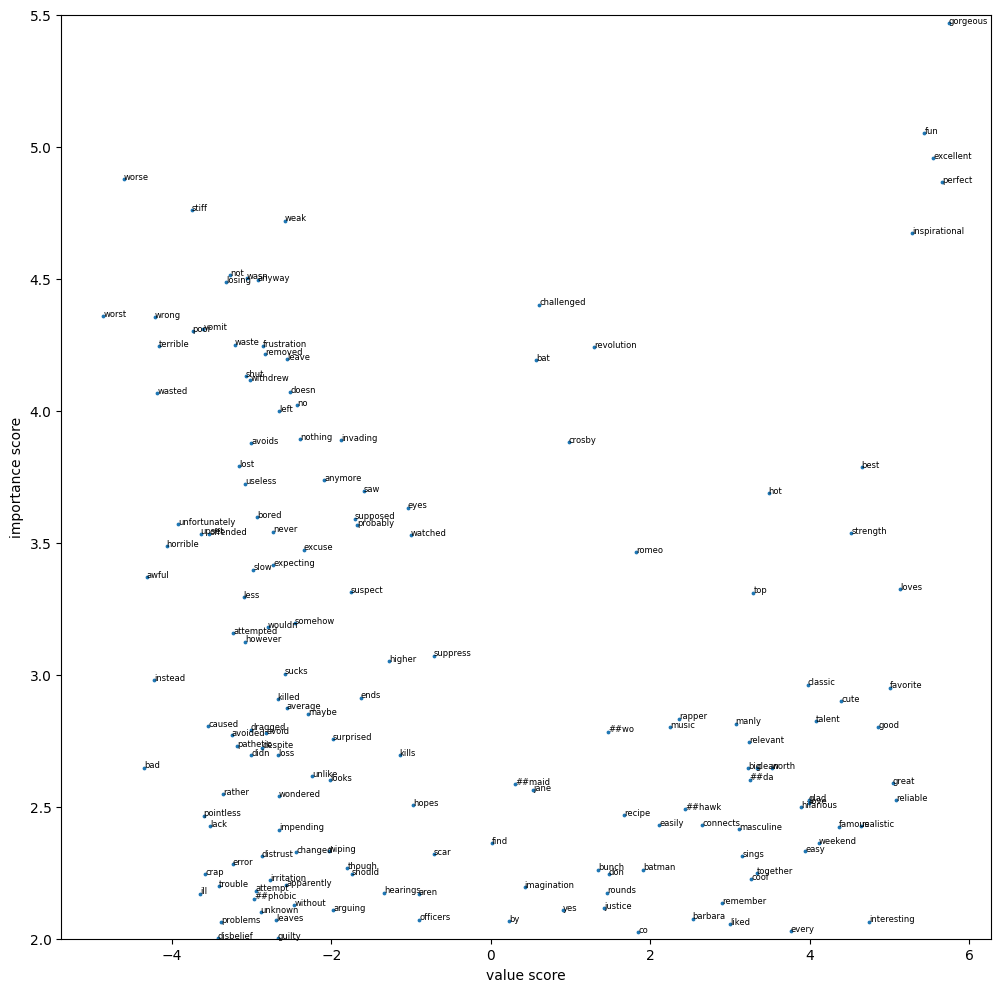

In [232]:
## Visualize only most important words
visualize_importances(unique_tokens, tokenizer, myslalomeff.curr_slalom_model, ylim=[2,5.5])

We can identify some tokens that affect the model differently than their original meaning
* **Postitive words with no directly postive meaning:** hot, big, together, remember
* **Negative words with no directly negative meaning:** anyway, somehow, never, anymore, nothing, probably, doesn, maybe, without, however, somehow, wouldn, surprised

In [210]:
new_text = """when my sister said this movie was gonna be good i had second thoughts but i watched it and it was actually funny.
basically the movie is made of a weird girl who goes to a small town where no one likes her and she just wants to go there and get the reading
of her aunts will don so she can go. but its not all that easy.
In this movie you will come across hilarious humor, a witch, a book of spells/recopies, a mentally challenged uncle and a dog.
You will understand the meaning of the word freak a after anyways i hope you run right out and try to find this really old movie.
hope you like it in total i will have to give it a 0.... no I'm totally joking ill give it a 9 hope you understand that you will laugh,
you will scream and you may just be offended.
love yours truly: Dakota you can email me at dakota_loves_it@hotmail.com if you wanna"""

In [211]:
new_text_input = new_text.replace("\n", " ")

In [212]:
forward_text(new_text_input)

Logit score:  1.5152696371078491


### Step 1: remove love in email

In [217]:
new_text = """when my sister said this movie was gonna be good i had second thoughts but i watched it and it was actually funny.
basically the movie is made of a weird girl who goes to a small town where no one likes her and she just wants to go there and get the reading
of her aunts will don so she can go. but its not all that easy.
In this movie you will come across hilarious humor, a witch, a book of spells/recopies, a mentally challenged uncle and a dog.
You will understand the meaning of the word freak a after anyways i hope you run right out and try to find this really old movie.
hope you like it in total i will have to give it a 0.... no I'm totally joking ill give it a 9 hope you understand that you will laugh,
you will scream and you may just be offended.
yours truly: Dakota you can email me at dakota_loves_it@hotmail.com if you wanna"""

In [218]:
forward_text(new_text.replace("\n", " "))

Logit score:  0.6806808710098267


### Step 2: No one likes her -> **however** no one likes her

In [219]:
new_text = """when my sister said this movie was gonna be good i had second thoughts but i watched it and it was actually funny.
basically the movie is made of a weird girl who goes to a small town however no one likes her and she just wants to go there and get the reading
of her aunts will don so she can go. but its not all that easy.
In this movie you will come across hilarious humor, a witch, a book of spells/recopies, a mentally challenged uncle and a dog.
You will understand the meaning of the word freak a after anyways i hope you run right out and try to find this really old movie.
hope you like it in total i will have to give it a 0.... no I'm totally joking ill give it a 9 hope you understand that you will laugh,
you will scream and you may just be offended.
yours truly: Dakota you can email me at dakota_loves_it@hotmail.com if you wanna"""

In [220]:
forward_text(new_text.replace("\n", " "))

Logit score:  0.5596814155578613


### Step 3: hope you like it -> **Anyway somehow** hope you like it

In [233]:
new_text = """when my sister said this movie was gonna be good i had second thoughts but i watched it and it was actually funny.
basically the movie is made of a weird girl who goes to a small town where she is not welcome and she just wants to go there and get the reading
of her aunts will don so she can go. but its not all that easy.
In this movie you will come across hilarious humor, a witch, a book of spells/recopies, a mentally challenged uncle and a dog.
You will understand the meaning of the word freak a after anyways i wish you run right out and try to find this really old movie. 
anyway somehow hope you like it in total i will have to give it a 0.... no I'm totally joking ill give it a 9 hope you understand that you will laugh,
you will scream and you may just be offended. 
yours truly: Dakota you can email me at dakota_loves_it@hotmail.com if you wanna"""

In [223]:
forward_text(new_text.replace("\n", " "))

Logit score:  0.09854307025671005


### Step 4: **Without doubt** you will come across

In [234]:
new_text = """when my sister said this movie was gonna be good i had second thoughts but i watched it and it was actually funny.
basically the movie is made of a weird girl who goes to a small town where she is not welcome and she just wants to go there and get the reading
of her aunts will don so she can go. but its not all that easy.
Without doubt in this movie you will come across hilarious humor, a witch, a book of spells/recopies, a mentally challenged uncle and a dog.
You will understand the meaning of the word freak a after anyways i wish you run right out and try to find this really old movie. 
anyway somehow hope you like it in total i will have to give it a 0.... no I'm totally joking ill give it a 9 hope you understand that you will laugh,
you will scream and you may just be offended. 
yours truly: Dakota you can email me at dakota_loves_it@hotmail.com if you wanna"""

In [235]:
forward_text(new_text.replace("\n", " "))

Logit score:  -0.5804972648620605


We see that we were able to exploit some weaknesses as pointed out by SLALOM to change the classification decision for this instance.